In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.linear_model import Ridge

class SLLR:
    def __init__(self, k_neighbors=10, reg_alpha=1e-3):
        self.k_neighbors = k_neighbors
        self.reg_alpha = reg_alpha
        self.points = None
        self.labels_one_hot = None
        self.nn_model = None

    def fit(self, X, y):
        self.points = X
        n_classes = int(np.max(y) + 1)
        self.labels = y
        self.labels_one_hot = np.eye(n_classes)[y]
        self.nn_model = NearestNeighbors(n_neighbors=self.k_neighbors, algorithm='auto')
        self.nn_model.fit(X)

    def predict(self, X):
        predictions = []
        dists, indices = self.nn_model.kneighbors(X)
        
        # Local Ridge Regression
        for i in range(len(X)):
            neighbor_indices = indices[i]
            X_local = self.points[neighbor_indices]
            y_local = self.labels_one_hot[neighbor_indices]
            
            # Center the local system
            center_X = np.mean(X_local, axis=0)
            X_local_centered = X_local - center_X
            target_centered = (X[i] - center_X).reshape(1, -1)
            
            # Fit Ridge Regression on neighbors
            model = Ridge(alpha=self.reg_alpha)
            model.fit(X_local_centered, y_local)
            
            pred_score = model.predict(target_centered)
            predictions.append(np.argmax(pred_score))
            
        return np.array(predictions)
    
    def predict_proba(self, X):
        predictions = []
        dists, indices = self.nn_model.kneighbors(X)
        
        for i in range(len(X)):
            neighbor_indices = indices[i]
            X_local = self.points[neighbor_indices]
            y_local = self.labels[neighbor_indices]
            
            # Center the local system
            center_X = np.mean(X_local, axis=0)
            X_local_centered = X_local - center_X
            target_centered = (X[i] - center_X).reshape(1, -1)
            
            # Fit Ridge Regression
            model = Ridge(alpha=self.reg_alpha)
            model.fit(X_local_centered, y_local)
            
            pred_score = model.predict(target_centered)
            
            # Clip to [0,1] to ensure valid probabilities
            prob = np.clip(pred_score.item(), 0.0, 1.0)
            predictions.append(prob)
            
        return np.array(predictions)

Loading MNIST data...
Starting Grid Search...
Sample sizes: [ 2000 17250 32500 47750 63000]
PCA Dims: [3, 4, 5, 6, 7, 8]
Running: n=63000, dims=8...
Grid Search Complete.


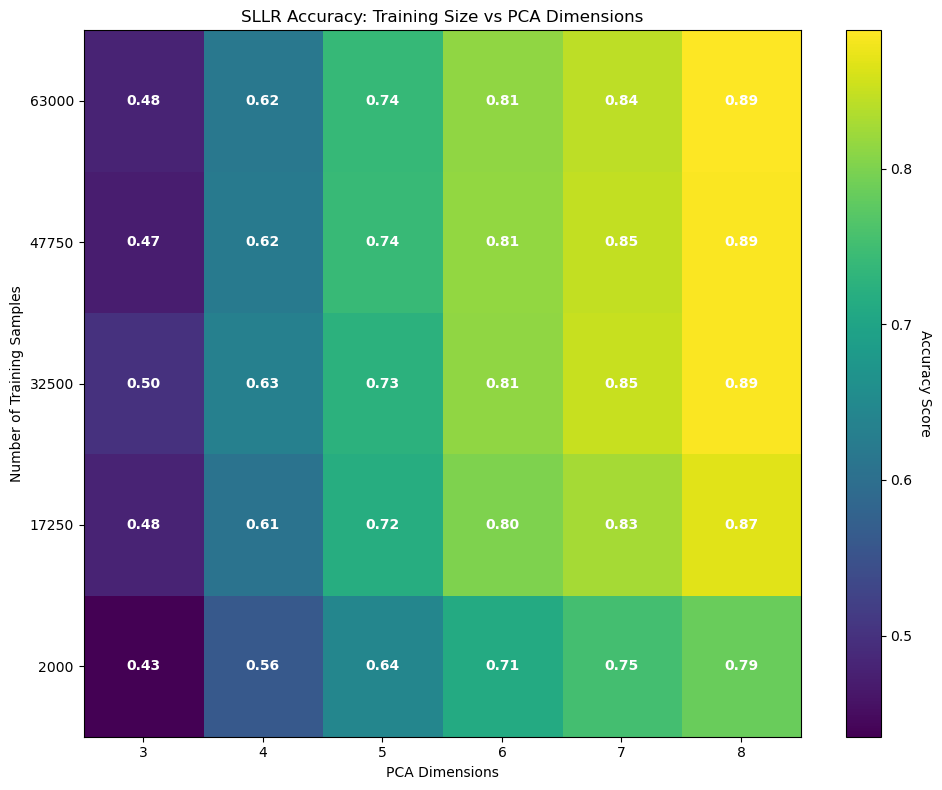

In [14]:
print("Loading MNIST data...")
X_raw, y_raw = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='auto')
y_raw = y_raw.astype(int)
X_raw = X_raw / 255.0

X_train_full, X_test, y_train_full, y_test = train_test_split(X_raw, y_raw, test_size=0.1, random_state=42)

pca_dims_list = range(3, 9)  # 3 to 8
n_samples_list = np.linspace(2000, len(X_train_full), 5, dtype=int)

accuracy_grid = np.zeros((len(n_samples_list), len(pca_dims_list)))
noise_level = 0.20

print(f"Starting Grid Search...")
print(f"Sample sizes: {n_samples_list}")
print(f"PCA Dims: {list(pca_dims_list)}")

for i, n_samples in enumerate(n_samples_list):
    
    indices = np.random.choice(len(X_train_full), n_samples, replace=False)
    X_current_train = X_train_full[indices]
    y_current_train = y_train_full[indices]

    n_noise = int(noise_level * n_samples)
    noise_indices = np.random.choice(n_samples, n_noise, replace=False)
    y_train_noisy = y_current_train.copy()
    
    for idx in noise_indices:
        current_label = y_current_train[idx]
        possible = list(range(10))
        possible.remove(current_label)
        y_train_noisy[idx] = np.random.choice(possible)

    for j, pca_dims in enumerate(pca_dims_list):
        print(f"Running: n={n_samples}, dims={pca_dims}...", end="\r")
        
        pca = PCA(n_components=pca_dims)
        X_train_pca = pca.fit_transform(X_current_train)
        X_test_pca = pca.transform(X_test) # Transform test set using the same projection
        
        k = max(10, pca_dims * 5)
        model = SLLR(k_neighbors=k)
        model.fit(X_train_pca, y_train_noisy)
        
        preds = model.predict(X_test_pca[:1000])
        acc = accuracy_score(y_test[:1000], preds)
        
        accuracy_grid[i, j] = acc

print("\nGrid Search Complete.")

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(accuracy_grid, cmap="viridis", origin="lower", aspect="auto")

ax.set_xticks(np.arange(len(pca_dims_list)))
ax.set_yticks(np.arange(len(n_samples_list)))

ax.set_xticklabels(pca_dims_list)
ax.set_yticklabels(n_samples_list)

ax.set_xlabel("PCA Dimensions")
ax.set_ylabel("Number of Training Samples")
ax.set_title("SLLR Accuracy: Training Size vs PCA Dimensions")

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Accuracy Score", rotation=-90, va="bottom")

for i in range(len(n_samples_list)):
    for j in range(len(pca_dims_list)):
        text = ax.text(j, i, f"{accuracy_grid[i, j]:.2f}",
                       ha="center", va="center", color="w", fontweight="bold")

plt.tight_layout()
plt.show()

In [ ]:
# --- Data Generation ---
def sigmoid(z): 
    return 1.0 / (1.0 + np.exp(-z))

def make_logistic_gaussian_data(n, d, gamma=2.0, p_noise=0.2, seed=0):
    rng = np.random.default_rng(seed)
    X = rng.normal(0.0, 1.0, size=(n, d))
    
    # Dense teacher vector
    u = rng.normal(0.0, 1.0, size=d)
    u /= np.linalg.norm(u)
    
    eta = sigmoid(gamma * (X @ u))
    y_clean = (rng.random(n) < eta).astype(int)
    
    # Add noise
    y = y_clean.copy()
    flips = rng.random(n) < p_noise
    y[flips] = 1 - y[flips]
    
    return X, y, y_clean

Running SLLR Experiment across dimensions [10, 20, 30, 40, 50, 60]...
Training set size: 50000

Processing Dimension d=10 (k=60)...
  Noise 0.00 -> 1NN: 0.694, SLLR: 0.767
  Noise 0.05 -> 1NN: 0.679, SLLR: 0.758
  Noise 0.10 -> 1NN: 0.644, SLLR: 0.751
  Noise 0.20 -> 1NN: 0.609, SLLR: 0.700
  Noise 0.30 -> 1NN: 0.542, SLLR: 0.648

Processing Dimension d=20 (k=120)...
  Noise 0.00 -> 1NN: 0.653, SLLR: 0.735
  Noise 0.05 -> 1NN: 0.628, SLLR: 0.731
  Noise 0.10 -> 1NN: 0.604, SLLR: 0.711
  Noise 0.20 -> 1NN: 0.562, SLLR: 0.661
  Noise 0.30 -> 1NN: 0.527, SLLR: 0.630

Processing Dimension d=30 (k=180)...
  Noise 0.00 -> 1NN: 0.596, SLLR: 0.702
  Noise 0.05 -> 1NN: 0.581, SLLR: 0.689
  Noise 0.10 -> 1NN: 0.577, SLLR: 0.672
  Noise 0.20 -> 1NN: 0.568, SLLR: 0.643
  Noise 0.30 -> 1NN: 0.551, SLLR: 0.586

Processing Dimension d=40 (k=240)...
  Noise 0.00 -> 1NN: 0.597, SLLR: 0.742
  Noise 0.05 -> 1NN: 0.569, SLLR: 0.728
  Noise 0.10 -> 1NN: 0.560, SLLR: 0.718
  Noise 0.20 -> 1NN: 0.544, SLLR: 

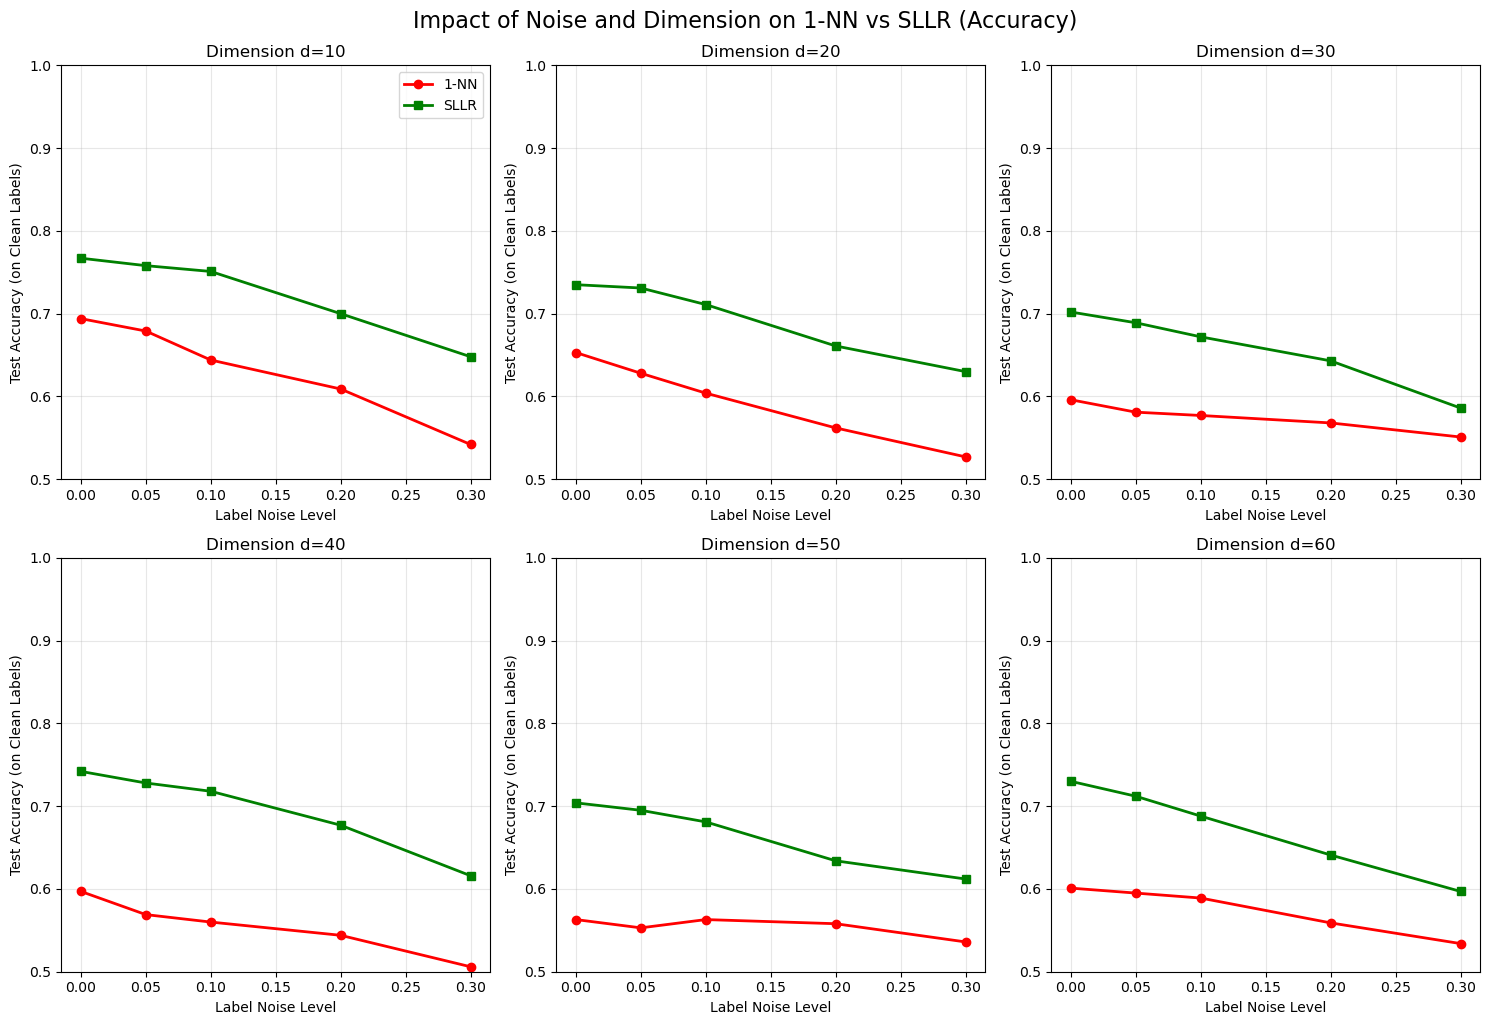

In [ ]:
d_values = range(10,61 , 10)
noise_levels = [0.0, 0.05, 0.1, 0.2, 0.3]
seeds = range(5)

n_train = 50000  
n_test = 200

results = {}

print(f"Running SLLR Experiment across dimensions {list(d_values)}...")
print(f"Training set size: {n_train}")

for d in d_values:
    results[d] = {'noise': [], '1nn_acc': [], 'sllr_acc': []}
    
    k_sllr = max(10, d * 6)
    
    print(f"\nProcessing Dimension d={d} (k={k_sllr})...")
    
    for noise in noise_levels:
        temp_1nn = []
        temp_sllr = []
        
        for s in seeds:
            X_total, y_noisy_total, y_clean_total = make_logistic_gaussian_data(
                n_train + n_test, d, gamma=2.0, p_noise=noise, seed=s
            )
            
            Xtr = X_total[:n_train]
            ytr = y_noisy_total[:n_train]
            
            Xte = X_total[n_train:]
            yte = y_clean_total[n_train:]
            
            m1 = KNeighborsClassifier(n_neighbors=1)
            m1.fit(Xtr, ytr)
            temp_1nn.append(np.mean(m1.predict(Xte) == yte))
            
            ms = SLLR(k_neighbors=k_sllr)
            ms.fit(Xtr, ytr)
            temp_sllr.append(np.mean(ms.predict(Xte) == yte))
            
        results[d]['noise'].append(noise)
        results[d]['1nn_acc'].append(np.mean(temp_1nn))
        results[d]['sllr_acc'].append(np.mean(temp_sllr))
        
        print(f"  Noise {noise:.2f} -> 1NN: {np.mean(temp_1nn):.3f}, SLLR: {np.mean(temp_sllr):.3f}")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, d in enumerate(d_values):
    ax = axes[i]
    data = results[d]
    
    ax.plot(data['noise'], data['1nn_acc'], 'r-o', label='1-NN', linewidth=2)
    ax.plot(data['noise'], data['sllr_acc'], 'g-s', label='SLLR', linewidth=2)
    
    ax.set_title(f"Dimension d={d}")
    
    ax.set_xlabel("Label Noise Level")
    ax.set_ylabel("Test Accuracy (on Clean Labels)")
    ax.set_ylim(0.5, 1.0) # Adjusted Y-lim for better visibility of high acc
    ax.grid(True, alpha=0.3)
    
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.suptitle("Impact of Noise and Dimension on 1-NN vs SLLR (Accuracy)", y=1.02, fontsize=16)
plt.show()

Testing SLLR (k=60) against Corollary 3.3 Bound...


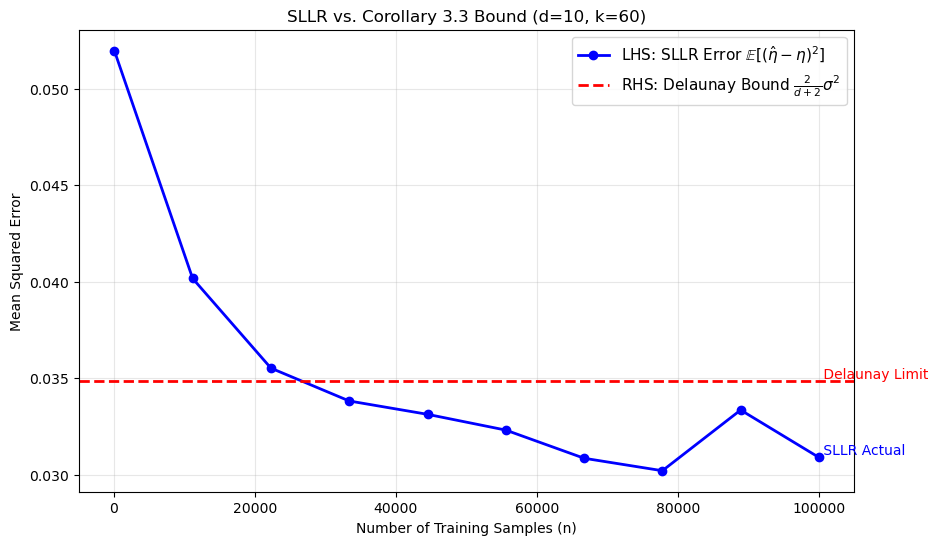

In [22]:
def get_true_eta(X, u, gamma, p_noise):
    """Calculates the TRUE P(Y=1|X) accounting for label flip noise."""
    eta_clean = sigmoid(gamma * (X @ u))
    # Adjust for label flipping: P(Y=1) = P(clean)*P(keep) + P(not_clean)*P(flip)
    eta_true = eta_clean * (1 - p_noise) + (1 - eta_clean) * p_noise
    return eta_true

# --- 3. Simulation ---
def verify_sllr(d=2, max_n=100000, p_noise=0.2, k=15):
    # Fixed Test Set
    n_test = 2000
    rng_test = np.random.default_rng(42)
    X_test = rng_test.uniform(-2, 2, size=(n_test, d)) # Uniform test within range
    
    # Fixed True Parameter u
    u_fixed = rng_test.normal(0.0, 1.0, size=d)
    u_fixed /= np.linalg.norm(u_fixed)
    
    # Calculate Ground Truth Eta
    eta_test = get_true_eta(X_test, u_fixed, gamma=2.0, p_noise=p_noise)
    
    # Theoretical Limit for Delaunay (The Red Line)
    # Variance of Y: E[eta(1-eta)]
    irreducible_error = np.mean(eta_test * (1 - eta_test))
    rhs_bound = (2 / (d + 2)) * irreducible_error
    
    n_samples_list = np.linspace(100, max_n, 10, dtype=int)
    lhs_values = []
    
    print(f"Testing SLLR (k={k}) against Corollary 3.3 Bound...")
    
    for n_train in n_samples_list:
        # Generate Training Data
        rng = np.random.default_rng()
        X_train = rng.normal(0.0, 1.0, size=(n_train, d))
        
        eta_train = get_true_eta(X_train, u_fixed, gamma=2.0, p_noise=p_noise)
        y_train = (rng.random(n_train) < eta_train).astype(int)
        
        # Fit SLLR
        model = SLLR(k_neighbors=k, reg_alpha=0.01)
        model.fit(X_train, y_train)
        
        # Predict Probabilities
        eta_hat = model.predict_proba(X_test)
        
        # Calculate MSE: E[(eta_hat - eta_true)^2]
        mse = np.mean((eta_hat - eta_test)**2)
        lhs_values.append(mse)
        
    return n_samples_list, lhs_values, rhs_bound

# --- 4. Execution ---
D = 10
K_NEIGHBORS = 60 
P_NOISE = 0.2

n_vals, lhs, rhs = verify_sllr(d=D, k=K_NEIGHBORS, p_noise=P_NOISE)

# --- 5. Plotting ---
plt.figure(figsize=(10, 6))

plt.plot(n_vals, lhs, marker='o', color='blue', linewidth=2, label=r'LHS: SLLR Error $\mathbb{E}[(\hat{\eta} - \eta)^2]$')
plt.axhline(y=rhs, color='red', linestyle='--', linewidth=2, label=r'RHS: Delaunay Bound $\frac{2}{d+2} \sigma^2$')

plt.xlabel('Number of Training Samples (n)')
plt.ylabel('Mean Squared Error')
plt.title(f'SLLR vs. Corollary 3.3 Bound (d={D}, k={K_NEIGHBORS})')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Annotation
plt.text(n_vals[-1], rhs, ' Delaunay Limit', color='red', va='bottom')
plt.text(n_vals[-1], lhs[-1], ' SLLR Actual', color='blue', va='bottom')

plt.show()